# Rate vs Cross section

In general we can write the relation between Rate, $\frac{dR}{d\Omega}$, and the Cross Section, $\frac{d\sigma}{d\Omega}$: 

$$
\frac{dR}{d\Omega} = \epsilon_{spettrometer}(\theta) \frac{N_{gate}}{T} n_c \wp(\theta; \lambda, \lambda') \frac{d\sigma}{d\Omega}
$$
 
where $n_{gate}$ is the number of photons that open the gate and $n_e$ is the density of scattering centers. 

## Geometry parameters

In [26]:
import matplotlib.pyplot as plt
import numpy as np

r_gate = 1.27  #cm
d_gate_source = 18.54 #cm
d_sorg_targ = 4.5 #cm
target_width = 1 #cm 
beta_2 = np.arctan(r_gate / d_gate_source)
r = d_sorg_targ * np.tan(beta_2)
Omega =  (1 - np.cos(beta_2))*2*np.pi #sr   
print (Omega, "str")

0.01468969384187046 str


## Physical parameters

In [27]:
r_e = 2.817e-13  # Classical electron radius in cm
m_e = 511  # Electron rest mass energy in keV
alpha = 1 / 137  # Fine-structure constant (dimensionless)
N_a = 6.022e23 # mol^(-1)

## Calculus of the density of scattering center
We can think that at first approximation, $n_c$ is the number of electrons in the illuminated region of the target, and so it follow the following equation:
$$
n_c = \rho \frac{N_aZ}{\text{MM}}
$$
where: 
- $\rho$ is the density of the scattering target
- $N_a$ is the Avogadro number
- $\text{MM}$ is the molar mass of the scattering target
- $Z$ is the atomic number

In [28]:
#For a Cu target
rho = 8.96 #g/cm^3
Z = 29 #number of electrons
MM = 63.546 #g/mol

n_c = rho *Z* (N_a / MM) 
print(n_c)

2.46239964749945e+24


## Calculus of the number of photons that open the gate
We can think at the number of photons at second that open the gate as: 

$$
\frac{N_{gate}}{T} = \frac{2 S(t) T\text{BR}}{T}\frac{\Delta\Omega}{4\pi}\epsilon_{gate}(511) = 2 S(t) \text{BR}\frac{\Delta\Omega}{4\pi}\epsilon_{gate}(511)
$$

where: 
- $S(t)$ is the activity of the source in Bq
- $\text{BR}$ is the branching ratio of the 511 keV photon
- $T$ is the time of the measurment
- $\frac{\Delta\Omega}{4\pi}$ is the solid angle
- $\epsilon_{gate}(511)$ is the efficiency of the gate detector for the 511 keV photon

In [29]:
S = 188900 #Bq
BR = 0.903
epsilon_gate = 0.147

flux = (2 * S * BR) * (Omega / (4 * np.pi)) * epsilon_gate #s^-1
print(flux, "s^-1")

58.623253720358576 s^-1


# Calculus of the probability factor

We can write (for riflection) $\wp(\theta; \lambda, \lambda')$ as: 
$$
\wp(\theta; \lambda, \lambda') = \lambda'' (1-e^{-\frac{D'}{\lambda''}})
$$

where: 
- $D' = \frac{D}{\cos(\frac{\pi - \theta}{2})}$ and $D$ is the target width
- $\lambda'' = \frac{\lambda\lambda'}{\lambda'+\lambda}$
- $\lambda$ is the mean free path for a 511 keV photon 
- $\lambda'$ is the mean free path for the photon after the scattering


We can also compile the probability factor for trasmission :

$$
\wp(\theta; \lambda, \lambda') = \lambda'' \cdot e^{-D / \lambda'} \cdot \left(1 - e^{-D / \lambda''} \right)

$$
where  $\lambda'' = \frac{\lambda\lambda'}{\lambda'-\lambda}$

-----------------------------------------------------

Secondo me il probability factor in trasmissione è diverso:

Definiamo:
$$
\alpha = \frac{1}{\lambda} - \frac{1}{\lambda' \cos\theta}
$$

Allora l'integrale
$$
\int_0^d e^{-x/\lambda} \cdot e^{-(d - x)/(\lambda' \cos\theta)} \, dx
$$

diventa:
$$
e^{-d/(\lambda' \cos\theta)} \cdot \frac{1 - e^{-\alpha d}}{\alpha}
$$




### Cross section calculus

In [30]:
def cross_section_thomson():
    """
    Calculate the Thomson cross-section, which represents the scattering 
    of electromagnetic waves by free electrons at low photon energies.

    :return: Thomson cross-section in square meters.
    """
    return (8 / 3) * np.pi * r_e ** 2


def cross_section_photoelectric(energy: float, Z: float) -> float:
    """
    Calculate the photoelectric cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Photoelectric cross-section in square meters.
    """
    bond_energy = 0.0047  # Example binding energy in keV
    gamma = (energy + m_e - bond_energy) / m_e 
    c = (3 / 2) * (alpha ** 4) * cross_section_thomson()  # Coefficient based on fine-structure constant

    return c * (
        ((Z * m_e / energy) ** 5) *
        (gamma ** 2 - 1) ** (3/2) *
        (
            (4/3) + (gamma * (gamma - 2) / (gamma + 1)) *
            (
                1 - (1 / (2 * gamma * (gamma ** 2 - 1)**(1/2))) *
                np.log((gamma + (gamma ** 2 - 1)**(1/2)) / (gamma - (gamma ** 2 - 1)**(1/2)))
            )
        )
    )


def cross_section_compton(energy: float, Z: float) -> float:
    """
    Calculate the Compton scattering cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Compton cross-section in square meters.
    """
    epsilon = energy / m_e  # Ratio of photon energy to electron rest mass energy

    # Define calculations for high and low energy regimes
    # These calculations are already vectorized if epsilon is an array
    
    # High energy part
    c_high = 2 * np.pi * r_e ** 2  # Coefficient based on Thomson cross-section
    # Handle potential division by zero if epsilon can be zero or very small.
    # For energy > 100 MeV, epsilon is large.
    term1_high = (1 + epsilon) / epsilon ** 2
    term2_high = (2 * (1 + epsilon) / (1 + 2 * epsilon)) - (np.log(1 + 2 * epsilon) / epsilon)
    term3_high = np.log(1 + 2 * epsilon) / (2 * epsilon)
    term4_high = (1 + 3 * epsilon) / (1 + 2 * epsilon) ** 2
    result_high = c_high * Z * (term1_high * term2_high + term3_high - term4_high)

    # Low energy part
    c_low = cross_section_thomson() 
    poly_term = (
        1 + 2 * epsilon + (6/5) * epsilon ** 2 - (1/2) * epsilon ** 3 +
        (2/7) * epsilon ** 4 - (6/35) * epsilon ** 5 + (8/105) * epsilon ** 6 + (4/105) * epsilon ** 7
    )
    result_low = c_low * Z * (1 / (1 + 2 * epsilon) ** 2) * poly_term
    
    # Use np.where to choose between high and low energy calculations
    return np.where(energy > 100, result_high, result_low)

### $\lambda$ calculus
$$
\lambda = \frac{1}{n_c\sigma_{tot}}
$$

In [31]:
def attenuation_factor(total_cross_section: float, density_of_scattering_centers: float) -> float:
    """
    Calculate the attenuation factor for a photon traveling through a material.

    :param total_cross_section: Total cross-section for the interaction (in cm²).
    :param scattering_target: Material properties (e.g., density, molar mass).
    :return: Attenuation factor (inverse mean free path).
    """
    return total_cross_section * density_of_scattering_centers # cm^-1

def attenuation_length(attenuation_factor: float) -> float:
    """
    Calculate the attenuation length for a photon traveling through a material.

    :param attenuation_factor: Attenuation factor (inverse mean free path).
    :return: Attenuation length in cm.
    """
    return 1 / attenuation_factor  # cm


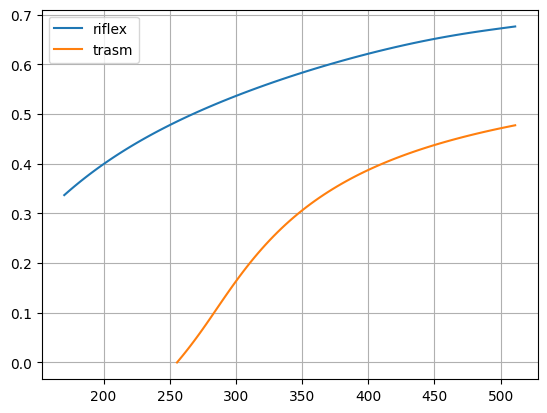

In [32]:
def compton_scattering(theta):
    return 511 / (2 - np.cos(theta))

def prob_riflex(theta):
    D_prime = target_width / np.cos((np.pi - theta)/2)
    E = 511
    E_prime = compton_scattering(theta)
    lam = attenuation_length(attenuation_factor(cross_section_compton(E, Z) + cross_section_photoelectric(E, Z), rho * (N_a / MM)))
    lam_prime = attenuation_length(attenuation_factor(cross_section_compton(E_prime, Z) + cross_section_photoelectric(E_prime, Z), rho  *(N_a / MM)))
    lam_dubprime = (lam * lam_prime) / (lam_prime + lam)
    
    return lam_dubprime * (1 - np.exp(-D_prime / lam_dubprime))


def prob_trasm(thetas): 
    D = 1
    E = 511
    
    thetas = np.asarray(thetas)
    cos_theta = np.cos(thetas)

    # Evita divisioni per zero (cos(pi/2) = 0)
    mask_safe = ~np.isclose(cos_theta, 0)
    
    # Prealloca output
    result = np.zeros_like(thetas)
    
    # Energia diffusa
    E_prime = compton_scattering(thetas)

    # Coefficienti di attenuazione
    mu = attenuation_factor(
        cross_section_compton(E, Z) + cross_section_photoelectric(E, Z),
        rho * (N_a / MM)
    )
    mu_prime = attenuation_factor(
        cross_section_compton(E_prime, Z) + cross_section_photoelectric(E_prime, Z),
        rho * (N_a / MM)
    )
    
    # Lunghezze di attenuazione
    lam = attenuation_length(mu)
    lam_prime = attenuation_length(mu_prime)
    
    # Array mascherati (solo dove cos_theta ≠ 0)
    ct = cos_theta[mask_safe]
    lp = lam_prime[mask_safe]
    
    alpha = (1 / lam) - (1 / (lp * ct))
    exponent = -D / (lp * ct)

    # Proteggi da overflow nei logaritmi
    exponent = np.clip(exponent, -700, 700)
    alphaD = alpha * D

    # Gestione alpha ≈ 0: espansione in serie
    near_zero_mask = np.isclose(alpha, 0)
    regular_mask = ~near_zero_mask

    # Computa dove alpha ≠ 0
    result_safe = np.zeros_like(alpha)
    result_safe[regular_mask] = np.exp(exponent[regular_mask]) * (1 - np.exp(-alphaD[regular_mask])) / alpha[regular_mask]

    # Computa dove alpha ≈ 0 → lim (1 - e^{-αD}) / α ≈ D
    result_safe[near_zero_mask] = D * np.exp(-D / lam)

    # Inserisce i risultati solo nelle posizioni sicure
    result[mask_safe] = result_safe

    return result




thetas = np.linspace(0, np.pi, 100)
plt.plot(compton_scattering(thetas), prob_riflex(thetas), label ="riflex")
thetas = np.linspace(0, np.pi/2, 100)
plt.plot(compton_scattering(thetas), prob_trasm(thetas), label = "trasm")
plt.legend()
plt.grid()
plt.show()

## Calculus of the efficiency

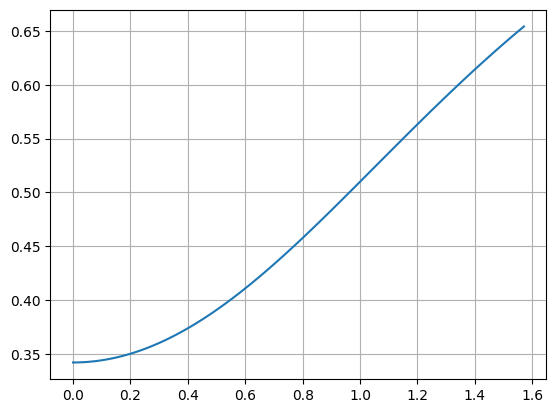

In [33]:
def epsilon_spettrometer(theta): 
    A = 1.5604
    B = -0.0995
    C = 3.53466
    D = 0.10210
   
    E  = compton_scattering(theta) * 1e-3 #da MeV a keV

    return A * pow(E, -B) * np.exp(-C * E) + D

plt.plot(thetas, epsilon_spettrometer(thetas))
plt.grid()
plt.show()

## Total correction 

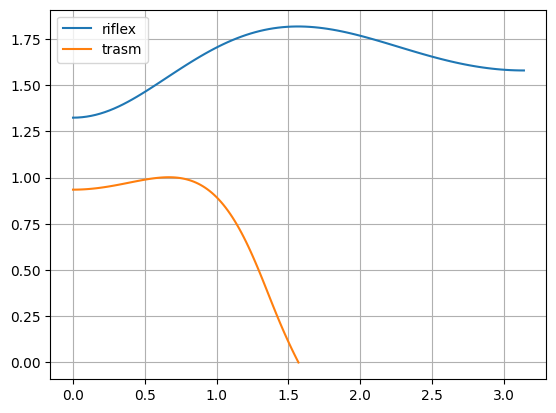

In [34]:
def const_riflex (theta):
    return (r_e ** 2 / 2) * n_c * flux * prob_riflex(theta) * epsilon_spettrometer(theta)

def const_trasm (theta):
    return (r_e ** 2 / 2) * n_c * flux * prob_trasm(theta) * epsilon_spettrometer(theta)

thetas = np.linspace(0, np.pi, 100)
plt.plot(thetas, const_riflex(thetas), label = "riflex")
thetas = np.linspace(0, np.pi/2, 100)
plt.plot(thetas, const_trasm(thetas),label = "trasm")
plt.legend()
plt.grid()
plt.show()

## Klein-Nishina
$$
\frac{d\sigma}{d\Omega} = \bigg(\frac{\omega'}{\omega}\bigg)^2\bigg[\frac{\omega'}{\omega} + \frac{\omega}{\omega'} - \sin^2(\theta)\bigg]
$$


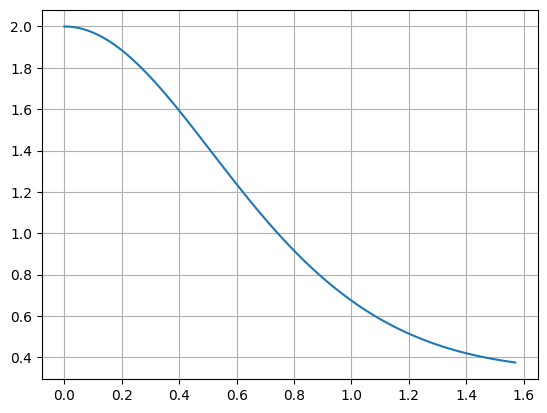

In [35]:
#andamento funzionale della KN
def klein_nishina(theta):
    E = compton_scattering(theta)
    r = E / 511
    return r ** 2 * (r + 1/r - np.sin(theta) ** 2)

plt.plot(thetas, klein_nishina(thetas))
plt.grid()
plt.show()

In [36]:
values_ref = np.array([0.02735079041747454, 0.025819652026622272, 0.027070509615309143, 
                   0.026302777950659273, 0.026575610155933342, 0.02669072072779364,
                   0.026320830435048827, 0.02677502814759899])

values_trasm = np.array([0.026686807818702276, 0.02735079041747454, 0.025819652026622272, 0.027070509615309143])

In [37]:
#lettura dati

def leggi_dati(file_path):
    # Inizializza liste per ogni colonna
    angle, rate, err_rate = [], [], []
    count, err_count = [], []
    channel, err_channel = [], []
    sigma, err_sigma = [], []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Salta l'intestazione
        for line in lines[1:]:
            valori = line.strip().split()
            if len(valori) != 9:
                continue  # Salta righe non valide

            angle.append(float(valori[0]))
            rate.append(float(valori[1]))
            err_rate.append(float(valori[2]))
            count.append(float(valori[3]))
            err_count.append(float(valori[4]))
            channel.append(float(valori[5]))
            err_channel.append(float(valori[6]))
            sigma.append(float(valori[7]))
            err_sigma.append(float(valori[8]))

    return angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma

file_path = "../../Codes/data_analysis/parameters_pol4_riflection.txt"

angle, rate, err_rate, count, err_count, channel, err_channel, sigma, err_sigma = leggi_dati(file_path)

file_path = "../../Codes/data_analysis/parameters_pol4_trasmission.txt"

angle_trasm, rate_trasm, err_rate_trasm, count_trasm, err_count_trasm, channel_trasm, err_channel_trasm, sigma_trasm, err_sigma_trasm = leggi_dati(file_path)

In [38]:
data = np.load('../../Measurments/errori_arrays_riflex.npz')
y_err = data['y_err']
x_err = data['x_err']

print(y_err, x_err)

data = np.load('../../Measurments/errori_arrays_trasm.npz')
y_err_trasm = data['y_err']
x_err_trasm = data['x_err']

print(y_err_trasm, x_err_trasm)

[0.22289512 0.38301662 0.3321584  0.23652001 0.17027142 0.15843568
 0.18042156 0.19280968] [0.06164475 0.06240437 0.06654412 0.07365252 0.08385656 0.09761824
 0.11575736 0.13962862]
[0.21717622 0.2031974  0.18256311 0.17366187] [0.06296861 0.06164788 0.06240445 0.06654608]


## Complete Klein-Nishina (with correction)

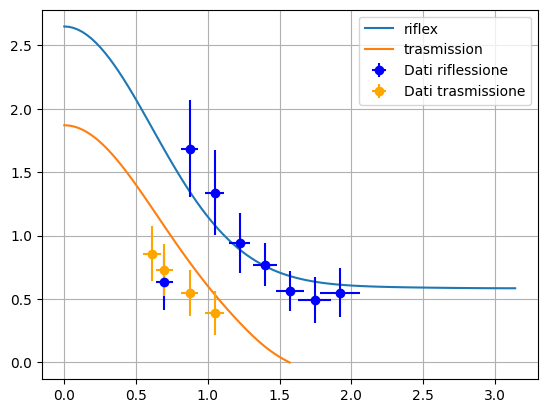

In [39]:
def rate_function_riflex(theta):
    return const_riflex(theta) * klein_nishina(theta) 

def rate_function_trasm(theta):
    return const_trasm(theta) * klein_nishina(theta)


angles = np.radians(angle)
angles_trasm = np.radians(angle_trasm)

# Dividi ogni rate per il corrispondente valore di angle_spectrometer
corrected_rates = rate / values_ref

corrected_rates_trasm = rate_trasm / values_trasm

thetas = np.linspace(0, np.pi, 100)
plt.plot(thetas, rate_function_riflex(thetas),label="riflex")
thetas = np.linspace(0, np.pi/2, 100)
plt.plot(thetas, rate_function_trasm(thetas), label ="trasmission")

plt.errorbar(angles, corrected_rates, yerr=y_err, xerr=x_err, fmt='o', color='blue', label='Dati riflessione')
plt.errorbar(angles_trasm, corrected_rates_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', color='orange', label='Dati trasmissione')
plt.grid()
plt.legend()
plt.show()

## **FIT FREQUENTISTA**

TRASMISSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  28e-27   │   4e-27   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 0.02, NDF: 3.0


/tmp/ipykernel_832/2949923612.py:62: RuntimeWarning: overflow encountered in exp
  result_safe[regular_mask] = np.exp(exponent[regular_mask]) * (1 - np.exp(-alphaD[regular_mask])) / alpha[regular_mask]


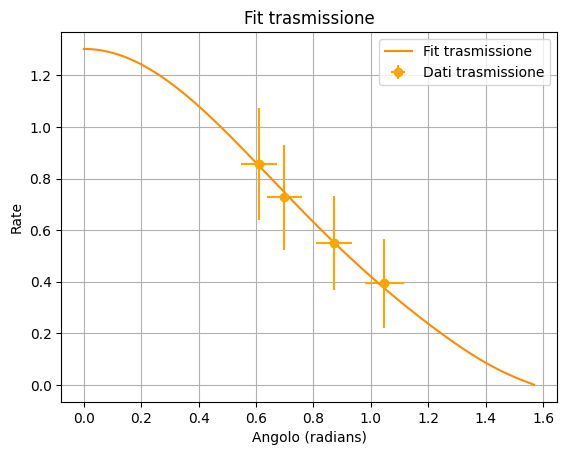


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 2.763574012621449e-26
Error on a: 4.2519679565659716e-27
r_e (true): 2.817e-13
Valore di r_e: 2.350988733542315e-13
Incertezza su r_e: 1.8085871258767736e-14
Compatibilità:  2.576659204249119


In [40]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

# === Funzione da fittare ===
def fit_function_trasm(theta, a):
    return klein_nishina(theta) * flux * n_c * prob_trasm(theta) * epsilon_spettrometer(theta) * a

# === Fit ===
least_squares_trasm = LeastSquares(angles_trasm, corrected_rates_trasm, y_err_trasm, fit_function_trasm)
m_trasm = Minuit(least_squares_trasm, a=1.0)
m_trasm.migrad()

# === Risultati ===
print("TRASMISSIONE")
print(m_trasm.params)
print(f"Chi2: {m_trasm.fval:.2f}, NDF: {m_trasm.ndof}")

# === Plot ===
plt.errorbar(angles_trasm, corrected_rates_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', color='orange', label='Dati trasmissione')
fit_theta_fine = np.linspace(0, np.pi/2, 2000)
a_fit_trasm = m_trasm.values["a"]
plt.plot(fit_theta_fine, fit_function_trasm(fit_theta_fine, a_fit_trasm), label="Fit trasmissione", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit trasmissione")
plt.show()

# === Calcolo r_e ===
a_err_trasm = m_trasm.errors["a"]
f_trasm = np.sqrt(2 * a_fit_trasm)
f_err_trasm = (1 / np.sqrt(2 * a_fit_trasm)) * a_err_trasm

print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_trasm}")
print(f"Error on a: {a_err_trasm}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f_trasm}")
print(f"Incertezza su r_e: {f_err_trasm}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (r_e - f_trasm)/ f_err_trasm
print ("Compatibilità: ", R)


RIFLESSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  40e-27   │   4e-27   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 2.71, NDF: 6.0


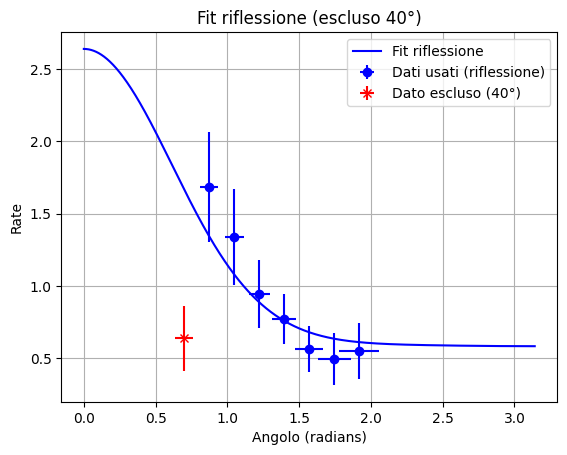


--- RISULTATI RIFLESSIONE ---
Fitted value of a: 3.9521991065954077e-26
Error on a: 4.004890484275071e-27
r_e (true): 2.817e-13
Valore di r_e: 2.8114761626574065e-13
Incertezza su r_e: 1.424479615893186e-14
Compatibilità:  0.038777931821298205


In [41]:
# === Escludi primo dato per il fit ===
angles_fit = angles[1:]
corrected_rates_fit = corrected_rates[1:]
y_err_fit = y_err[1:]
x_err_fit = x_err[1:]

# === Funzione da fittare ===
def fit_function_riflex(theta, a):
    return klein_nishina(theta) * flux * n_c * prob_riflex(theta) * epsilon_spettrometer(theta) * a

# === Fit ===
least_squares_riflex = LeastSquares(angles_fit, corrected_rates_fit, y_err_fit, fit_function_riflex)
m_riflex = Minuit(least_squares_riflex, a=1.0)
m_riflex.migrad()

# === Risultati ===
print("RIFLESSIONE")
print(m_riflex.params)
print(f"Chi2: {m_riflex.fval:.2f}, NDF: {m_riflex.ndof}")

# === Plot ===
plt.errorbar(angles[1:], corrected_rates[1:], yerr=y_err[1:], xerr=x_err[1:], fmt='o', color='blue', label='Dati usati (riflessione)')
plt.errorbar(angles[0], corrected_rates[0], yerr=y_err[0], xerr=x_err[0], fmt='x', color='red', label='Dato escluso (40°)')

fit_theta_fine = np.linspace(0, np.pi, 2000)
a_fit_riflex = m_riflex.values["a"]
plt.plot(fit_theta_fine, fit_function_riflex(fit_theta_fine, a_fit_riflex), label="Fit riflessione", color='blue')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit riflessione (escluso 40°)")
plt.show()

# === Calcolo r_e ===
a_err_riflex = m_riflex.errors["a"]
f_riflex = np.sqrt(2 * a_fit_riflex)
f_err_riflex = (1 / np.sqrt(2 * a_fit_riflex)) * a_err_riflex

print("\n--- RISULTATI RIFLESSIONE ---")
print(f"Fitted value of a: {a_fit_riflex}")
print(f"Error on a: {a_err_riflex}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f_riflex}")
print(f"Incertezza su r_e: {f_err_riflex}")

# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (r_e - f_riflex)/ f_err_riflex
print ("Compatibilità: ", R)


TOTALE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 31.8e-27  │  1.3e-27  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 26.53, NDF: 10.0


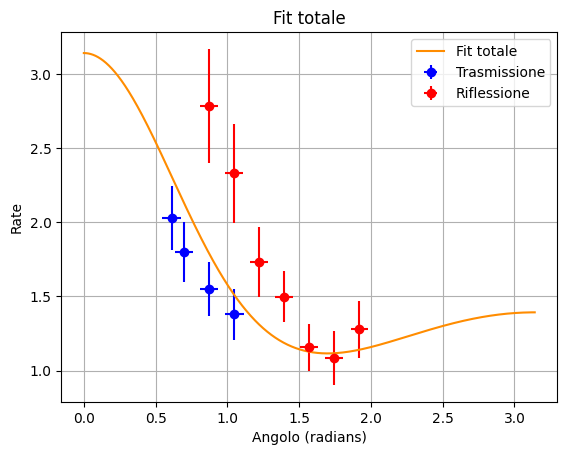


--- RISULTATI RIFLESSIONE ---
Fitted value of a: 3.1820547619328195e-26
Error on a: 1.2568778216841604e-27
r_e (true): 2.817e-13
Valore di r_e: 2.5227186771151555e-13
Incertezza su r_e: 4.982235368080986e-15
Compatibilità:  5.906612216078288


In [42]:
# === Dataset riflessione (con primo punto rimosso) ===
corrected_rates = corrected_rates[1:]
angles = angles[1:]
y_err = y_err[1:]

KN_riflex = corrected_rates / prob_riflex(angles)

# === Dataset trasmissione (completo) ===
KN_trasm = corrected_rates_trasm / prob_trasm(angles_trasm)

# === Dataset totale per il fit ===
KN_tot = np.concatenate((KN_trasm, KN_riflex))
angle_tot = np.concatenate((angles_trasm, angles))
KN_y_err = np.concatenate((y_err_trasm, y_err))

# === Funzione da fittare ===
def fit_function(theta, a):
    return klein_nishina(theta) * n_c * flux * epsilon_spettrometer(theta) * a

# === Fit ===
least_squares_trasm = LeastSquares(angle_tot, KN_tot, KN_y_err, fit_function)
m = Minuit(least_squares_trasm, a=1.0)
m.migrad()

# === Risultati ===
print("TOTALE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
thetas = np.linspace(0, np.pi, 2000)
a_fit = m.values["a"]

plt.errorbar(angles_trasm, KN_trasm, yerr=y_err_trasm, xerr=x_err_trasm, fmt='o', label="Trasmissione", color='blue')
plt.errorbar(angles, KN_riflex, yerr= y_err, xerr = x_err[:1], fmt='o', label="Riflessione", color='red')
plt.plot(thetas, fit_function(thetas, a_fit), label="Fit totale", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit totale")
plt.show()

# === Calcolo r_e ===
a_err = m.errors["a"]
f = np.sqrt(2 * a_fit)
f_err = (1 / np.sqrt(2 * a_fit)) * a_err

print("\n--- RISULTATI RIFLESSIONE ---")
print(f"Fitted value of a: {a_fit}")
print(f"Error on a: {a_err}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f}")
print(f"Incertezza su r_e: {f_err}")

# === Compatibilità ===
R = (r_e - f) / f_err
print("Compatibilità: ", R)


## Efficiency division

$$
\frac{N}{\Delta T \Omega_{spect}\epsilon_{spect}} = \frac{N_{gate}}{T} n_c \wp(\theta; \lambda, \lambda') \frac{d\sigma}{d\Omega}
$$

In [43]:
data = np.load('../../Measurments/errori_arrays_riflex_effSotto.npz')
y_err_eff = data['y_err']
x_err_eff = data['x_err']

data = np.load('../../Measurments/errori_arrays_trasm_effSotto.npz')
y_err_trasm_eff = data['y_err']
x_err_trasm_eff = data['x_err']

8 8 4 4
7 8 4 4


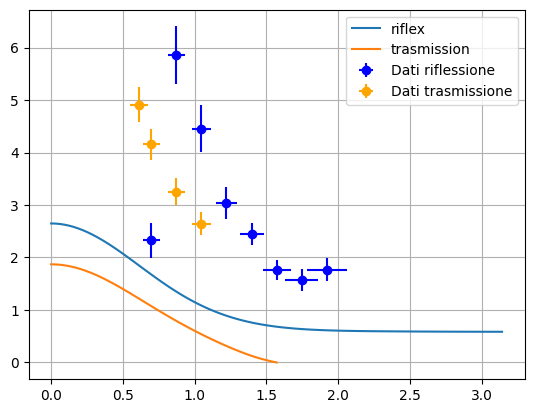

In [44]:
def rate_function(theta, a=(r_e ** 2 / 2)):
    return flux * n_c * klein_nishina(theta) * a

angles = np.radians([40, 50, 60, 70, 80, 90, 100, 110])
angles_trasm = np.radians(angle_trasm)

# Dividi ogni rate per il corrispondente valore di angle_spectrometer
corrected_rates = rate / (values_ref * epsilon_spettrometer(angles) * prob_riflex(angles))

corrected_rates_trasm = rate_trasm / (values_trasm * epsilon_spettrometer(angles_trasm) * prob_trasm(angles_trasm))

print(len(corrected_rates), len(angles), len(corrected_rates_trasm), len(angles_trasm))
print(len(y_err), len(x_err), len(y_err_trasm), len(x_err_trasm))

thetas = np.linspace(0, np.pi, 100)
plt.plot(thetas, rate_function_riflex(thetas),label="riflex")
thetas = np.linspace(0, np.pi/2, 100)
plt.plot(thetas, rate_function_trasm(thetas), label ="trasmission")

plt.errorbar(angles, corrected_rates, yerr=y_err_eff, xerr=x_err_eff, fmt='o', color='blue', label='Dati riflessione')
plt.errorbar(angles_trasm, corrected_rates_trasm, yerr=y_err_trasm_eff, xerr=x_err_trasm_eff, fmt='o', color='orange', label='Dati trasmissione')
plt.grid()
plt.legend()
plt.show()

TRASMISSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 27.8e-27  │  1.0e-27  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 0.50, NDF: 3.0


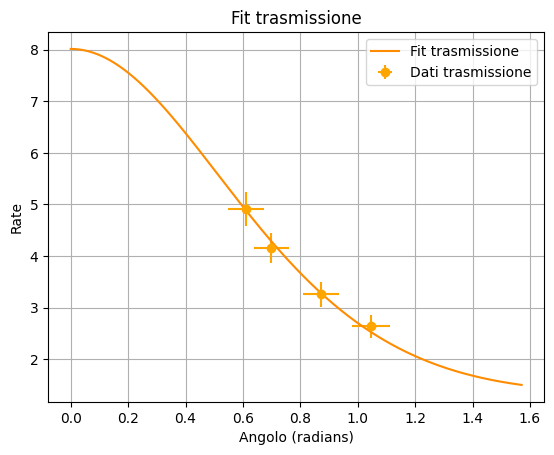


--- RISULTATI TRASMISSIONE ---
Fitted value of a: 2.7756246378543836e-26
Error on a: 1.0234216389992673e-27
r_e (true): 2.817e-13
Valore di r_e: 2.3561089269617327e-13
Incertezza su r_e: 4.3436940766528894e-15
Compatibilità:  10.610578574479517


In [45]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

# === Fit ===
least_squares_trasm = LeastSquares(angles_trasm, corrected_rates_trasm, y_err_trasm_eff, rate_function)
m_trasm = Minuit(least_squares_trasm, a=1.0)
m_trasm.migrad()

# === Risultati ===
print("TRASMISSIONE")
print(m_trasm.params)
print(f"Chi2: {m_trasm.fval:.2f}, NDF: {m_trasm.ndof}")

# === Plot ===
plt.errorbar(angles_trasm, corrected_rates_trasm, yerr=y_err_trasm_eff, xerr=x_err_trasm_eff, fmt='o', color='orange', label='Dati trasmissione')
fit_theta_fine = np.linspace(0, np.pi/2, 2000)
a_fit_trasm = m_trasm.values["a"]
plt.plot(fit_theta_fine, rate_function(fit_theta_fine, a_fit_trasm), label="Fit trasmissione", color='darkorange')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit trasmissione")
plt.show()

# === Calcolo r_e ===
a_err_trasm = m_trasm.errors["a"]
f_trasm = np.sqrt(2 * a_fit_trasm)
f_err_trasm = (1 / np.sqrt(2 * a_fit_trasm)) * a_err_trasm

print("\n--- RISULTATI TRASMISSIONE ---")
print(f"Fitted value of a: {a_fit_trasm}")
print(f"Error on a: {a_err_trasm}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f_trasm}")
print(f"Incertezza su r_e: {f_err_trasm}")


# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (r_e - f_trasm)/ f_err_trasm
print ("Compatibilità: ", R)


RIFLESSIONE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 38.9e-27  │  1.5e-27  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 17.51, NDF: 6.0


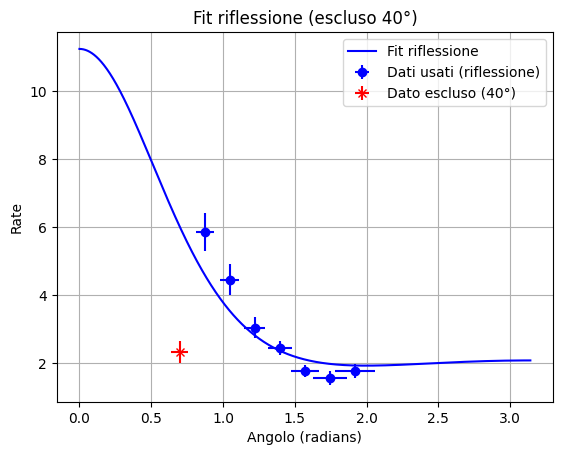


--- RISULTATI RIFLESSIONE ---
Fitted value of a: 3.8913913928831754e-26
Error on a: 1.550275625973653e-27
r_e (true): 2.817e-13
Valore di r_e: 2.789763930114222e-13
Incertezza su r_e: 5.557013657102448e-15
Compatibilità:  0.4901206217293966


In [46]:
# === Escludi primo dato per il fit ===
angles_fit = angles[1:]
corrected_rates_fit = corrected_rates[1:]
y_err_fit = y_err_eff[1:]
x_err_fit = x_err_eff[1:]

# === Fit ===
least_squares_riflex = LeastSquares(angles_fit, corrected_rates_fit, y_err_fit, rate_function)
m_riflex = Minuit(least_squares_riflex, a=1.0)
m_riflex.migrad()

# === Risultati ===
print("RIFLESSIONE")
print(m_riflex.params)
print(f"Chi2: {m_riflex.fval:.2f}, NDF: {m_riflex.ndof}")

# === Plot ===
plt.errorbar(angles[1:], corrected_rates[1:], yerr=y_err_eff[1:], xerr=x_err_eff[1:], fmt='o', color='blue', label='Dati usati (riflessione)')
plt.errorbar(angles[0], corrected_rates[0], yerr=y_err_eff[0], xerr=x_err_eff[0], fmt='x', color='red', label='Dato escluso (40°)')

fit_theta_fine = np.linspace(0, np.pi, 2000)
a_fit_riflex = m_riflex.values["a"]
plt.plot(fit_theta_fine, rate_function(fit_theta_fine, a_fit_riflex), label="Fit riflessione", color='blue')

plt.xlabel("Angolo (radians)")
plt.ylabel("Rate")
plt.legend()
plt.grid()
plt.title("Fit riflessione (escluso 40°)")
plt.show()

# === Calcolo r_e ===
a_err_riflex = m_riflex.errors["a"]
f_riflex = np.sqrt(2 * a_fit_riflex)
f_err_riflex = (1 / np.sqrt(2 * a_fit_riflex)) * a_err_riflex

print("\n--- RISULTATI RIFLESSIONE ---")
print(f"Fitted value of a: {a_fit_riflex}")
print(f"Error on a: {a_err_riflex}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f_riflex}")
print(f"Incertezza su r_e: {f_err_riflex}")

# === Confronto tra r_e ottenuti da riflessione e trasmissione ===
R = (r_e - f_riflex)/ f_err_riflex
print ("Compatibilità: ", R)


TOTALE
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │ 30.8e-27  │  0.6e-27  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
Chi2: 102.67, NDF: 10.0


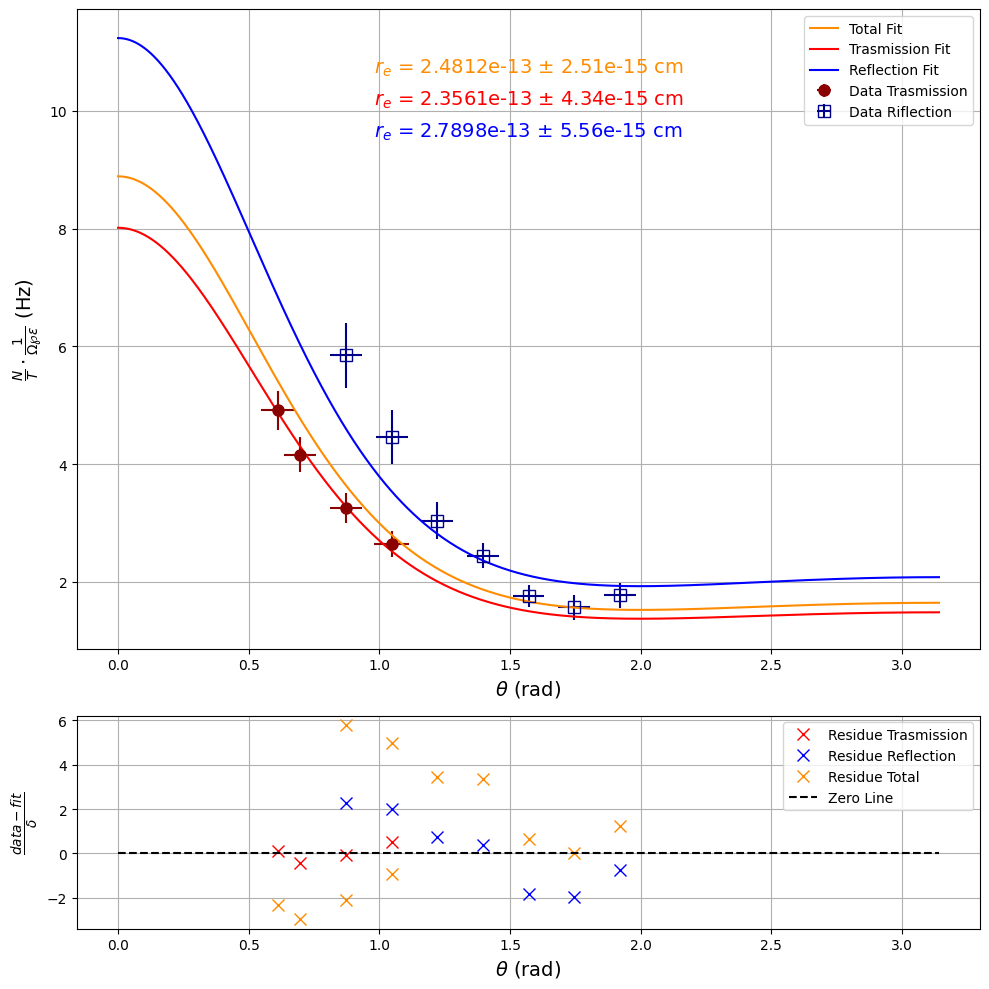


--- RISULTATI ---
Fitted value of a: 3.0781624622129345e-26
Error on a: 6.229027695774778e-28
r_e (true): 2.817e-13
Valore di r_e: 2.481194253666139e-13
Incertezza su r_e: 2.5104957770117965e-15
Compatibilità:  13.376072941798181


In [47]:
# === Dataset riflessione (con primo punto rimosso) ===
corrected_rates = corrected_rates[1:]
angles = angles[1:]
y_err_eff = y_err_eff[1:]

KN_riflex = corrected_rates 

# === Dataset trasmissione (completo) ===
KN_trasm = corrected_rates_trasm 

# === Dataset totale per il fit ===
KN_tot = np.concatenate((KN_trasm, KN_riflex))
angle_tot = np.concatenate((angles_trasm, angles))
KN_y_err = np.concatenate((y_err_trasm, y_err))

# === Fit ===
least_squares_trasm = LeastSquares(angle_tot, KN_tot, KN_y_err, rate_function)
m = Minuit(least_squares_trasm, a=1.0)
m.migrad()

# === Risultati ===
print("TOTALE")
print(m.params)
print(f"Chi2: {m.fval:.2f}, NDF: {m.ndof}")

# === Plot ===
thetas = np.linspace(0, np.pi, 2000)
a_fit = m.values["a"]

# === Calcolo r_e ===
a_err = m.errors["a"]
f = np.sqrt(2 * a_fit)
f_err = (1 / np.sqrt(2 * a_fit)) * a_err


fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})
ax[0].errorbar(angles_trasm, KN_trasm, 
             yerr=y_err_trasm_eff, 
             xerr=x_err_trasm_eff, 
             fmt='o', 
             label="Data Trasmission", 
             markersize=8,
             color='darkred')  

ax[0].errorbar(angles, KN_riflex, 
             yerr=y_err_eff, 
             xerr=x_err_eff[:1], 
             fmt='s', 
             label="Data Riflection",
             markersize=8, 
             markerfacecolor='none', 
             markeredgecolor="darkblue",
             ecolor='darkblue')
ax[0].plot(thetas, rate_function(thetas, a_fit), label="Total Fit", color='darkorange')
ax[0].plot(thetas, rate_function(thetas, a_fit_trasm), label="Trasmission Fit", color='red')
ax[0].plot(thetas, rate_function(thetas, a_fit_riflex), label="Reflection Fit", color='blue')

ax[0].text(0.5, 0.9, rf"$r_e$ = {f:.5g} ± {f_err:.3g} cm", color='darkorange', fontsize=14, transform=ax[0].transAxes, ha='center')
ax[0].text(0.5, 0.85, rf"$r_e$ = {f_trasm:.5g} ± {f_err_trasm:.3g} cm", color='red', fontsize=14, transform=ax[0].transAxes, ha='center')
ax[0].text(0.5, 0.8, rf"$r_e$ = {f_riflex:.5g} ± {f_err_riflex:.3g} cm", color='blue', fontsize=14, transform=ax[0].transAxes, ha='center')

ax[0].set_xlabel(r"$\theta$ (rad)", fontsize=14)
ax[0].set_ylabel(r"$\frac{N}{T}\cdot\frac{1}{\Omega\wp\epsilon}$ (Hz)", fontsize=14)
ax[0].legend()
ax[0].grid()

residue_trasm = (KN_trasm - rate_function(angles_trasm, a_fit_trasm)) / y_err_trasm_eff
residue_riflex = (KN_riflex - rate_function(angles, a_fit_riflex)) / y_err_eff
residue_tot = (KN_tot - rate_function(angle_tot, a_fit)) / KN_y_err

ax[1].plot(angles_trasm, residue_trasm, 'x', label='Residue Trasmission', color='red', markersize=8)
ax[1].plot(angles, residue_riflex, 'x', label='Residue Reflection', color='blue', markersize=8)
ax[1].plot(angle_tot, residue_tot, 'x', label='Residue Total', color='darkorange', markersize=8)
ax[1].hlines(0, 0, np.pi, colors='black', linestyles='dashed', label='Zero Line')
ax[1].set_xlabel(r"$\theta$ (rad)", fontsize=14)
ax[1].set_ylabel(r"$\frac{data - fit}{\delta}$", fontsize=14)
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.savefig("KN_fits.png")
plt.show()

print("\n--- RISULTATI ---")
print(f"Fitted value of a: {a_fit}")
print(f"Error on a: {a_err}")
print(f"r_e (true): {r_e}")
print(f"Valore di r_e: {f}")
print(f"Incertezza su r_e: {f_err}")

# === Compatibilità ===
R = (r_e - f) / f_err
print("Compatibilità: ", R)


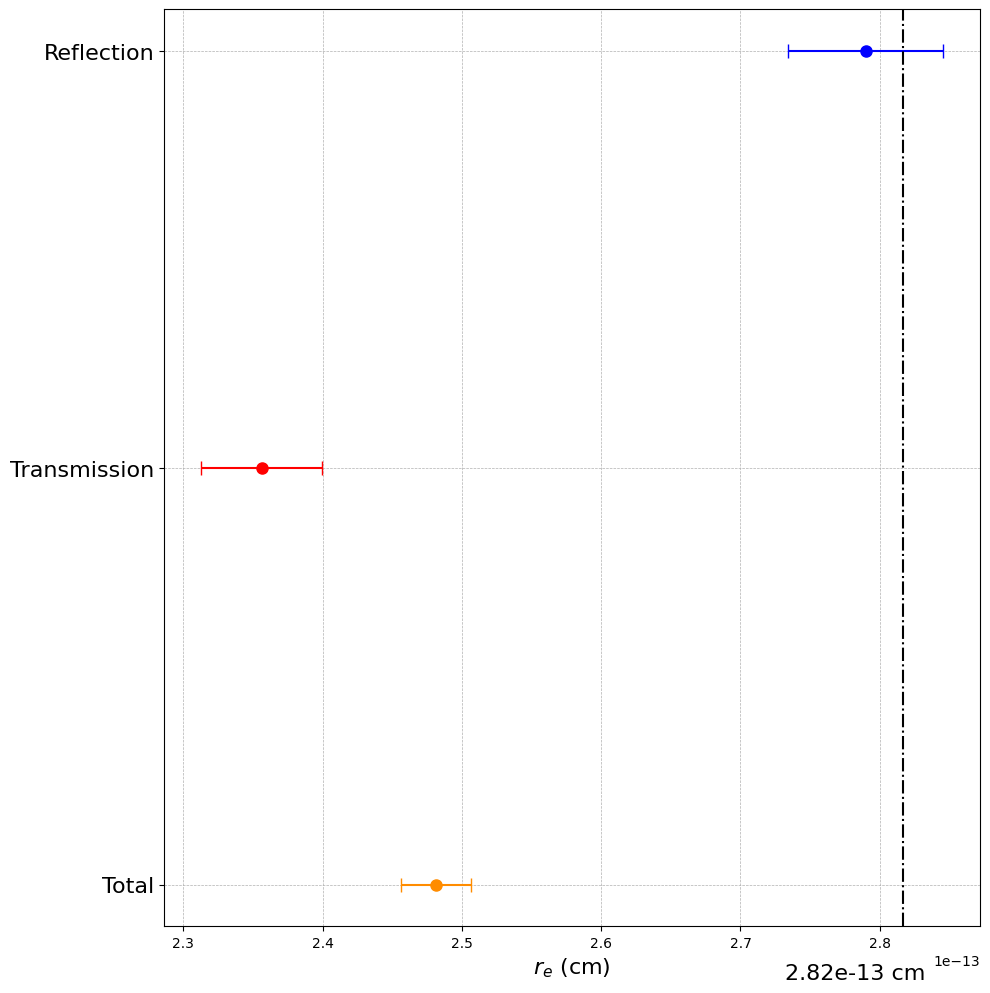

In [ ]:
# Creazione del plot
fig, ax = plt.subplots(figsize=(10, 10))

# Dati per il plot
y_labels = ['Reflection', 'Transmission', 'Total']
y_pos = np.arange(len(y_labels))
m_plot_values = [f_riflex, f_trasm, f]
m_plot_errors = [f_err_riflex, f_err_trasm, f_err]
colors = ['blue', 'red', 'darkorange']

# Plot delle singole misure con barre d'errore
for i in range(len(y_labels)):
    ax.errorbar(m_plot_values[i], y_pos[i], xerr=m_plot_errors[i], fmt='o', color=colors[i], capsize=5, markersize=8, label=y_labels[i])

# Plot della linea verticale per il valore atteso
ax.axvline(x=r_e, color='black', linestyle='-.')
ax.text(r_e-0.035e-13, -0.04, f'{r_e:.3g} cm', transform=ax.get_xaxis_transform(), ha='center', va='top', fontsize=16, color='black')

# Impostazioni del grafico
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=16)
ax.set_xlabel(r"$r_e$ (cm)", fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Inverti l'asse y per avere "Total" in basso
ax.invert_yaxis()

plt.tight_layout()
plt.savefig("Result_Rate.png")
plt.show()

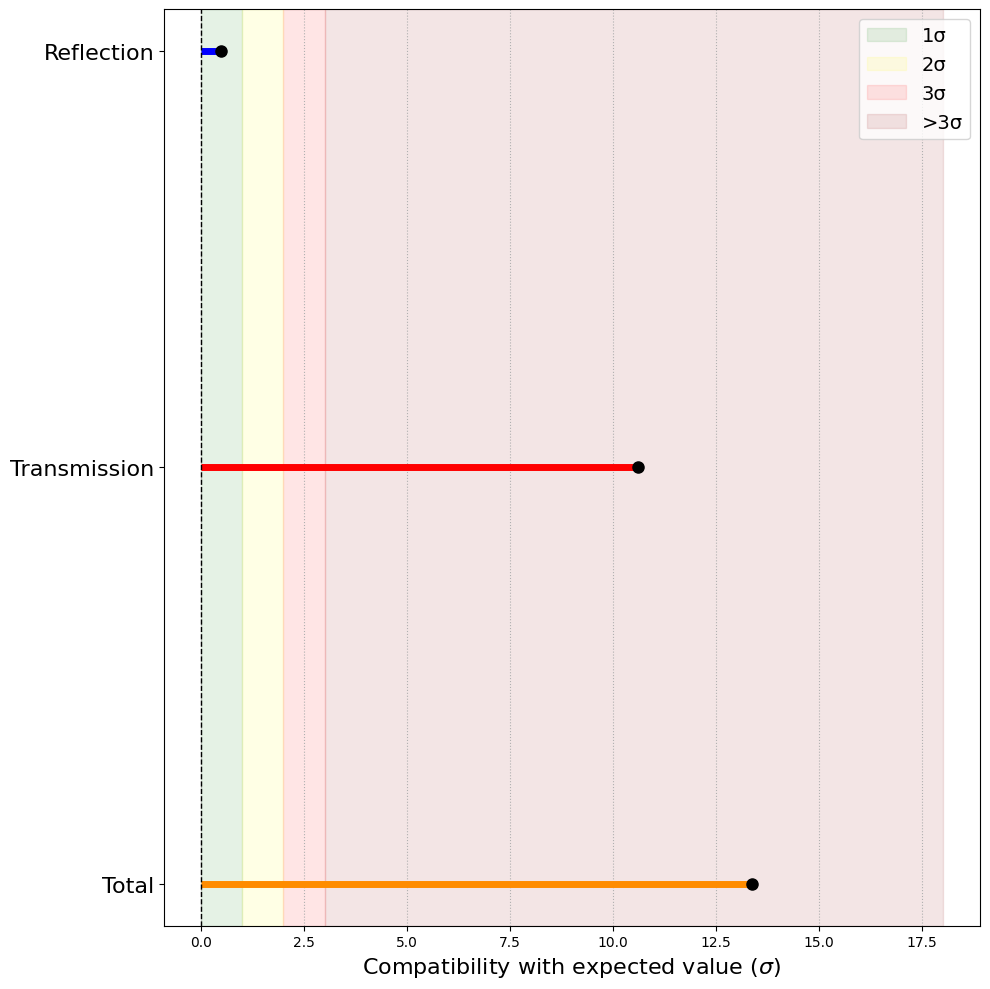

In [49]:
all_labels = ['Reflection', 'Transmission', 'Total']
all_values = np.array([f_riflex, f_trasm, f])
all_errors = np.array([f_err_riflex, f_err_trasm, f_err])

# Valore di riferimento
true_value = r_e

# Calcolo del pull: (valore_misurato - valore_vero) / errore_misura
pulls = np.abs((all_values - true_value) / all_errors)

# --- Creazione del Plot ---
fig, ax = plt.subplots(figsize=(10, 10))
y_pos = np.arange(len(all_labels))
colors = ['blue', 'red', 'darkorange', 'lightseagreen']

# Plotto i punti con una linea orizzontale da 0 al valore del pull
ax.hlines(y=y_pos, xmin=0, xmax=pulls, color=colors, lw=5)
ax.plot(pulls, y_pos, "o", color='black', markersize=8) # Aggiungo un punto alla fine di ogni linea

# Linea di riferimento a 0 (accordo perfetto)
ax.axvline(0, color='black', linestyle='--', lw=1)

# Bande di compatibilità a 1, 2, e 3 sigma
ax.axvspan(0, 1, alpha=0.1, color='green', label='1σ')
ax.axvspan(1, 2, alpha=0.1, color='yellow', label='2σ')
ax.axvspan(2, 3, alpha=0.1, color='red', label='3σ')
ax.axvspan(3, 18, alpha=0.1, color='darkred', label='>3σ')

# --- Impostazioni del Grafico ---
ax.set_yticks(y_pos)
ax.set_yticklabels(all_labels, fontsize=16)
ax.set_xlabel(r'Compatibility with expected value ($\sigma$)', fontsize=16)
ax.grid(axis='x', linestyle=':', which='both')
ax.legend(fontsize=14)

# Inverti l'asse y per avere "Reflection" in alto
ax.invert_yaxis()

plt.tight_layout()
plt.savefig("Compatibility_Rate.png")
plt.show()

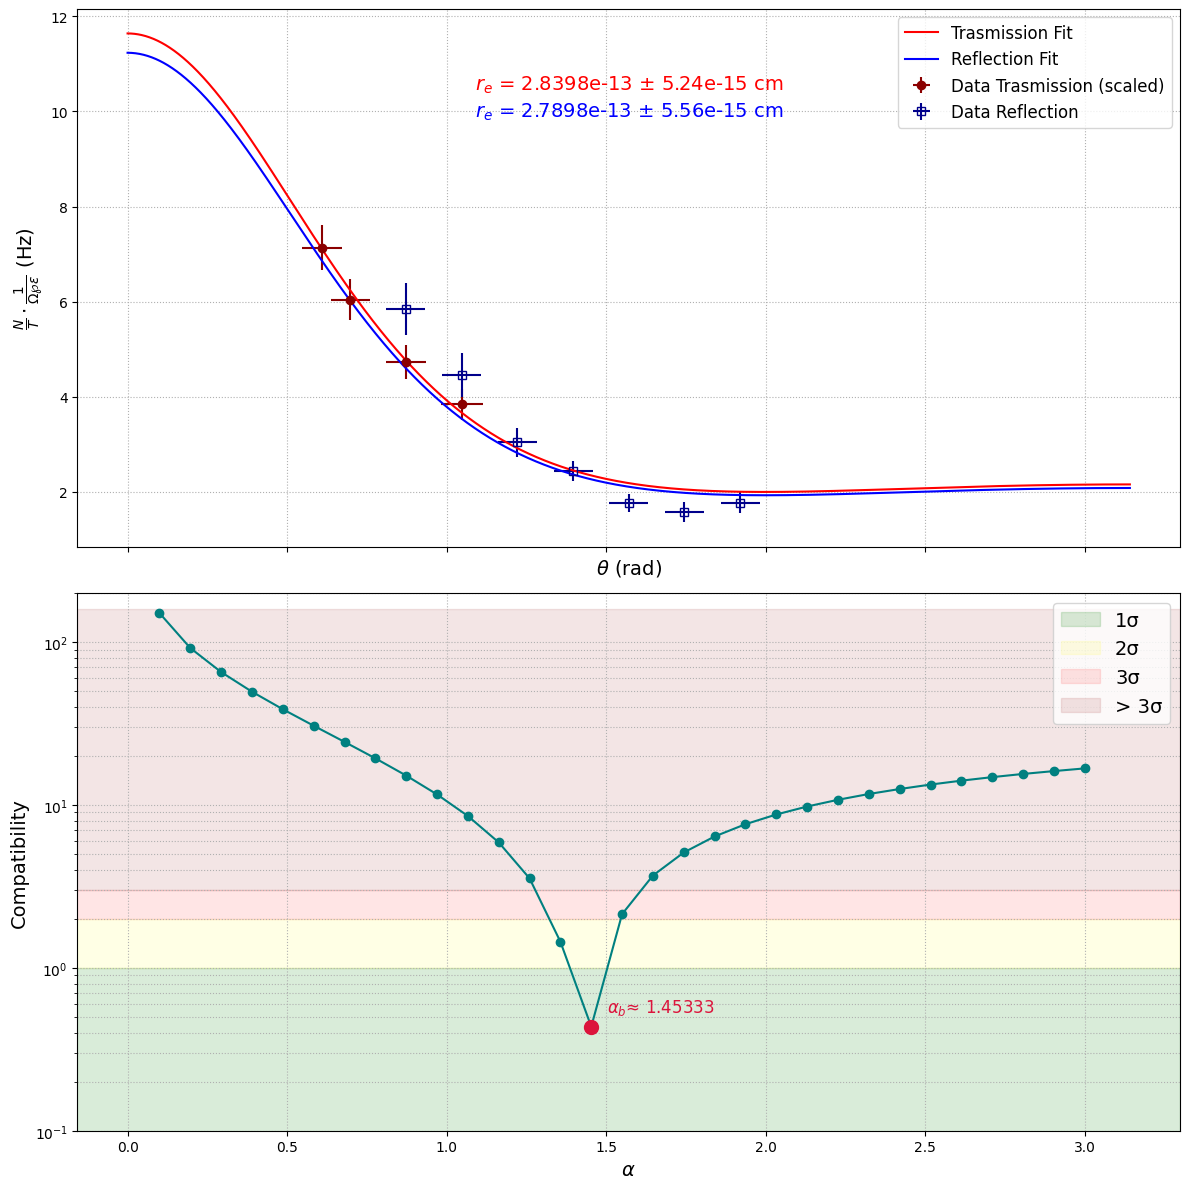

Il fattore alpha che rende il risultato più compatibile con il valore atteso è: 1.4533
Con questo fattore, il pull è 0.435 sigma.


In [81]:
# --- Studio del fattore correttivo alpha per i dati in trasmissione ---

# 1. Definizione dell'intervallo di valori per alpha
alphas = np.linspace(0.1, 3, 31)  # Esplora un range di fattori correttivi

# Liste per salvare i risultati
r_e_fits = []
r_e_errs = []
pulls = []
a_fits = [] # Lista per salvare il parametro 'a' di ogni fit

# Valore di riferimento (PDG)
r_e_true = r_e

# 2. Ciclo su ogni valore di alpha
for alpha in alphas:
    # Scala i dati di trasmissione e i relativi errori
    KN_trasm_scaled = KN_trasm * alpha
    y_err_trasm_eff_scaled = y_err_trasm_eff * alpha
    
    # 3. Esegui il fit SUI SOLI DATI DI TRASMISSIONE SCALATI
    least_squares_scaled = LeastSquares(angles_trasm, KN_trasm_scaled, y_err_trasm_eff_scaled, rate_function)
    m_scaled = Minuit(least_squares_scaled, a=1.0)
    m_scaled.migrad()
    m_scaled.hesse()
    
    # Se il fit è valido, calcola e salva i risultati
    if m_scaled.valid:
        a_fit_scaled = m_scaled.values["a"]
        a_err_scaled = m_scaled.errors["a"]
        
        # 4. Calcola r_e dal fit
        f_scaled = np.sqrt(2 * a_fit_scaled)
        f_err_scaled = (1 / np.sqrt(2 * a_fit_scaled)) * a_err_scaled
        
        # 5. Calcola il pull
        pull = np.abs((f_scaled - r_e_true) / f_err_scaled)
        
        r_e_fits.append(f_scaled)
        r_e_errs.append(f_err_scaled)
        pulls.append(pull)
        a_fits.append(a_fit_scaled)
    else:
        # Se il fit fallisce, aggiungi NaN per mantenere la corrispondenza
        r_e_fits.append(np.nan)
        r_e_errs.append(np.nan)
        pulls.append(np.nan)
        a_fits.append(np.nan)

# --- 6. Trova il valore ottimale di alpha ---
best_alpha_index = np.nanargmin(np.abs(pulls))
best_alpha = alphas[best_alpha_index]
best_pull = pulls[best_alpha_index]
best_a_fit = a_fits[best_alpha_index]

f_best = r_e_fits[best_alpha_index]
f_err_best = r_e_errs[best_alpha_index]


# --- 7. Creazione del Plot con Subplots ---
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# --- Subplot 1: Dati scalati con alpha ottimale e Fit ---
KN_trasm_scaled_best = KN_trasm * best_alpha
y_err_trasm_eff_scaled_best = y_err_trasm_eff * best_alpha

ax[0].errorbar(angles_trasm, KN_trasm_scaled_best, yerr=y_err_trasm_eff_scaled_best, xerr=x_err_trasm_eff, fmt='o', label="Data Trasmission (scaled)", color='darkred', markersize=6)
ax[0].errorbar(angles, KN_riflex, yerr=y_err_eff, xerr=x_err_eff[:1], fmt='s', label="Data Reflection", color='blue', markersize=6, markerfacecolor='none', markeredgecolor="darkblue", ecolor='darkblue')

ax[0].plot(thetas, rate_function(thetas, best_a_fit), label="Trasmission Fit", color='red')
ax[0].plot(thetas, rate_function(thetas, a_fit_riflex), label="Reflection Fit", color='blue')

ax[0].text(0.5, 0.85, rf"$r_e$ = {f_best:.5g} ± {f_err_best:.3g} cm", color='red', fontsize=14, transform=ax[0].transAxes, ha='center')
ax[0].text(0.5, 0.8, rf"$r_e$ = {f_riflex:.5g} ± {f_err_riflex:.3g} cm", color='blue', fontsize=14, transform=ax[0].transAxes, ha='center')

ax[0].set_xlabel(r"$\theta$ (rad)", fontsize=14)
ax[0].set_ylabel(r"$\frac{N}{T}\cdot\frac{1}{\Omega\wp\epsilon}$ (Hz)", fontsize=14)
ax[0].legend()
ax[0].grid()
ax[0].grid(True, linestyle=':', which='both')
ax[0].legend(fontsize=12)

# --- Subplot 2: Studio del Pull vs Alpha ---
ax[1].plot(alphas, pulls, 'o-', color='teal')
ax[1].axhline(0, color='black', linestyle='--', lw=1)
ax[1].axhspan(0, 1, alpha=0.15, color='green', label='1σ')
ax[1].axhspan(1, 2, alpha=0.1, color='yellow', label='2σ')
ax[1].axhspan(2, 3, alpha=0.1, color='red', label='3σ')
ax[1].axhspan(3, 160, alpha=0.1, color='darkred', label='> 3σ')

ax[1].plot(best_alpha, best_pull, 'o', markersize=10, color='crimson')
ax[1].text(best_alpha + 0.05, best_pull + 0.1, rf'$\alpha_b$≈ {best_alpha:.5f}', fontsize=12, color='crimson')

ax[1].set_xlabel(r'$\alpha$', fontsize=14)
ax[1].set_ylabel(r'Compatibility', fontsize=14)
ax[1].grid(True, linestyle=':', which='both')
ax[1].legend(fontsize=14)
ax[1].set_yscale('log')
ax[1].set_ylim(1e-1, 200)

plt.tight_layout()
plt.savefig("alpha_compatibility_study_trasmission_only.png")
plt.show()

print(f"Il fattore alpha che rende il risultato più compatibile con il valore atteso è: {best_alpha:.4f}")
print(f"Con questo fattore, il pull è {best_pull:.3f} sigma.")